In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# df_2009 = pd.read_excel("online+retail+ii/online_retail_II.xlsx", "Year 2009-2010")
# df_2010 = pd.read_excel("online+retail+ii/online_retail_II.xlsx", "Year 2010-2011")
df_2009 = pd.read_excel("online_retail_II.xlsx", "Year 2009-2010")
df_2010 = pd.read_excel("online_retail_II.xlsx", "Year 2010-2011")

display(f"2009 shape: {df_2009.shape}")
display(f"2010 shape: {df_2010.shape}")

'2009 shape: (525461, 8)'

'2010 shape: (541910, 8)'

In [3]:
df = pd.concat([df_2009, df_2010])
display(f"All shape: {df.shape}")

'All shape: (1067371, 8)'

In [4]:
df["Customer ID"].nunique()

5942

# Data Understanding

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


In [8]:
df["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts()

Invoice
______     1047871
C______      19494
A______          6
Name: count, dtype: int64

In [9]:
df[df["Invoice"].astype(str).str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [10]:
quantity_anomaly = df[df["Quantity"] < 0]

display(quantity_anomaly.head(5))
display(quantity_anomaly["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).unique())
display(quantity_anomaly["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


array(['_____', '_____A', '_____S', '_____D', '_____B', '_____E',
       '_____C', 'D', 'POST', '_____W', '_____N', '_____P', '_____GR',
       'M', '_____G', '_____J', '_____L', '_____I', 'BANK CHARGES',
       '_____F', '_____LP', '_____M', '_____K', 'gift________', '_____Y',
       '_____HC', 'ADJUST', '_____H', 'DCGSSGIRL', 'DCGS____', 'GIFT',
       '_____V', '_____R', 'DCGSLBOY', 'DCGSSBOY', 'DCGSLGIRL', '_____BL',
       'S', 'C_', '_____U', 'PADS', 'DOT', 'TEST___', 'SP____',
       'AMAZONFEE', '_____T', 'DCGS____P', 'CRUK'], dtype=object)

Invoice
C______    19493
______      3457
Name: count, dtype: int64

In [11]:
price_anomaly = df[df["Price"] < 0]
display(len(price_anomaly))
display(price_anomaly.head(5))
display(price_anomaly["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts())
display(price_anomaly["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).value_counts())

5

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Invoice
A______    5
Name: count, dtype: int64

StockCode
B    5
Name: count, dtype: int64

In [12]:
df.duplicated().sum()

np.int64(34335)

In [13]:
df_dup = df[df.duplicated(keep=False)]
df_dup.sort_values(by=df_dup.columns.tolist()).head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
379,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
391,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
365,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
363,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom


In [14]:
# display(df_stock_str.head(5))
display(df["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).unique())

array(['_____', '_____P', '_____W', '_____C', '_____B', '_____F',
       '_____L', '_____S', '_____A', '_____N', 'POST', '_____E', '_____J',
       '_____D', '_____G', '_____LP', '_____BL', 'D', '_____K', '_____H',
       '_____GR', '_____M', 'DCGS____', 'DOT', '_____U', '_____b',
       '_____w', '_____c', '_____a', '_____f', '_____bl', 'M', '_____s',
       '_____p', '_____R', '_____V', 'C_', '_____T', '_____I',
       'BANK CHARGES', '_____O', '_____Z', 'TEST___', 'gift________',
       'DCGS____N', '_____m', 'PADS', '_____Y', '_____HC', '_____e',
       '_____d', 'ADJUST', 'DCGSSGIRL', 'GIFT', 'DCGSLBOY', '_____k', 'm',
       '_____g', 'DCGSSBOY', 'DCGSLGIRL', 'S', '_____j', 'B', '_____l',
       '_____n', 'ADJUST_', '_____J ', 'SP____', 'AMAZONFEE', 'DCGS____P',
       'CRUK'], dtype=object)

In [15]:
stock_c = df[df["StockCode"].astype(str).str.startswith("C")]
display(len(stock_c))
display(stock_c.head(5))
display(stock_c["Description"].value_counts())

299

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
9292,490127,C2,CARRIAGE,1,2009-12-03 18:13:00,50.0,14156.0,EIRE
14481,490541,C2,CARRIAGE,1,2009-12-07 09:25:00,50.0,NaN,EIRE
14502,490542,C2,CARRIAGE,1,2009-12-07 09:42:00,50.0,14911.0,EIRE
19541,490998,C2,CARRIAGE,1,2009-12-08 17:24:00,50.0,16253.0,United Kingdom
22803,491160,C2,CARRIAGE,1,2009-12-10 10:29:00,50.0,14911.0,EIRE


Description
CARRIAGE           279
CRUK Commission     16
Name: count, dtype: int64

In [16]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

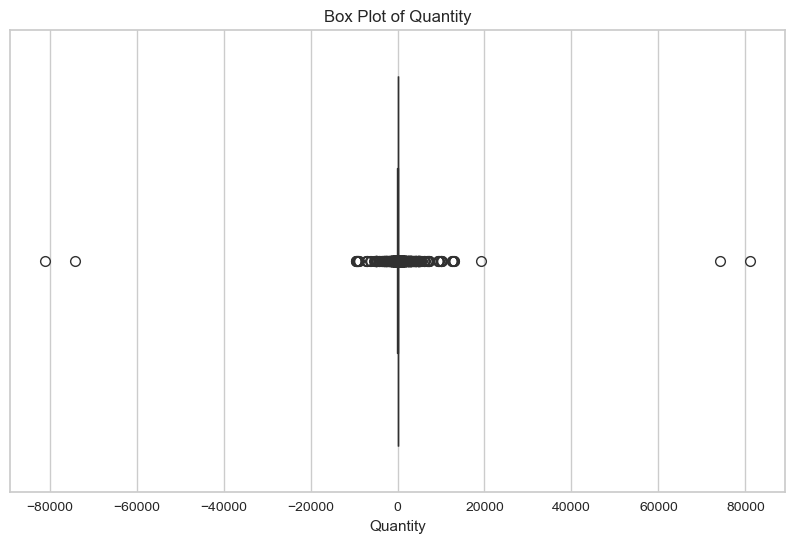

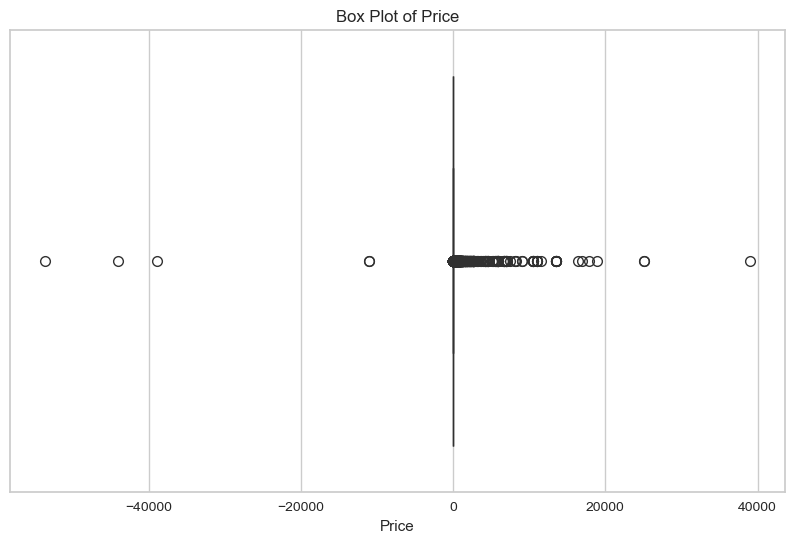

In [17]:
for feature in ["Quantity", "Price"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot of {feature}")
    plt.show()

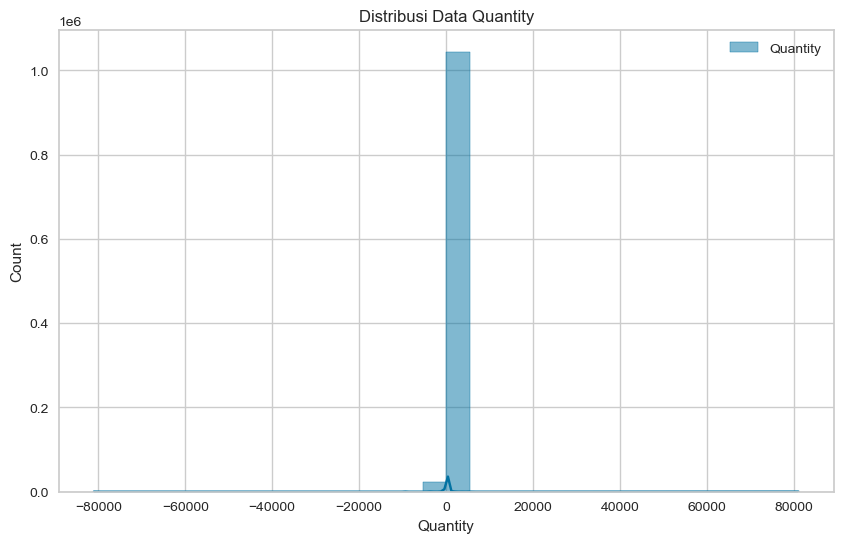

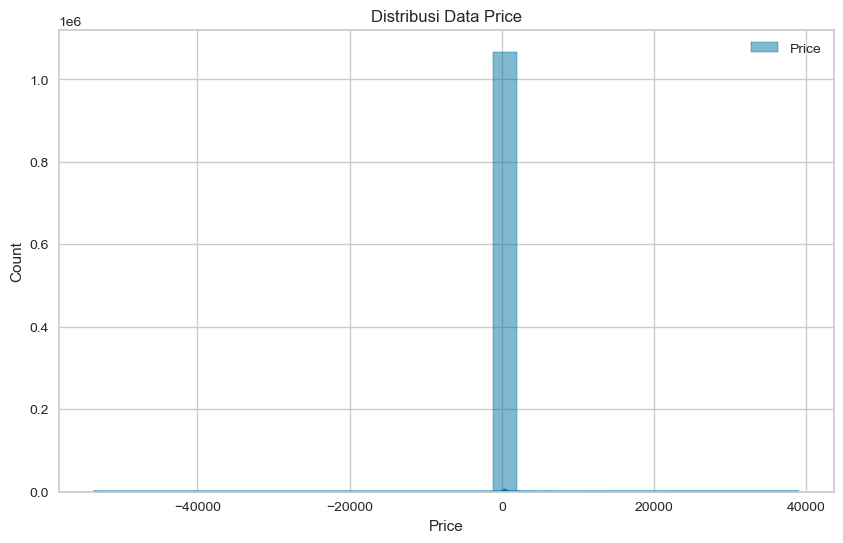

In [18]:
for feature in ["Quantity", "Price"]:
  plt.figure(figsize=(10, 6))
  sns.histplot(df[feature], kde=True, label=feature, bins=30, element='step')
  plt.title(f'Distribusi Data {feature}')
  plt.legend()
  plt.show()

## EDA

<Axes: xlabel='Quantity', ylabel='Description'>

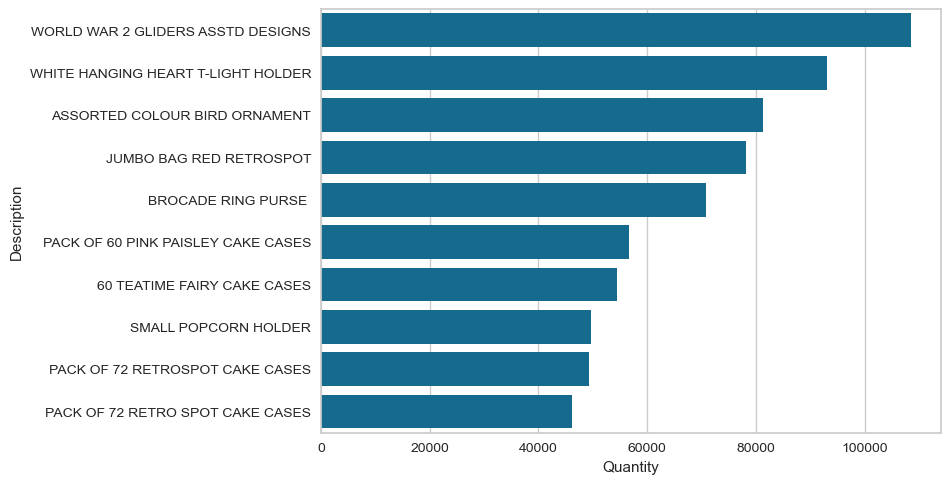

In [19]:
top_product = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

sns.barplot(top_product, orient="h")

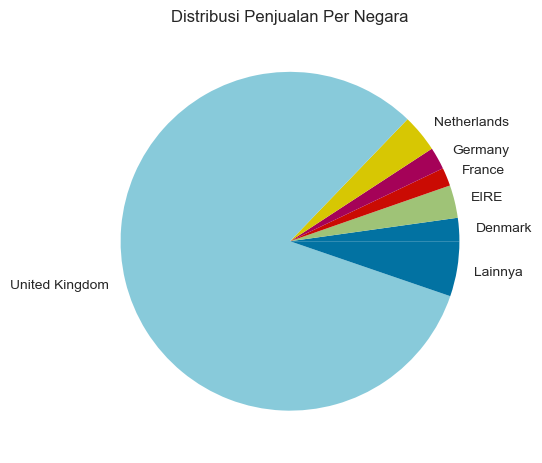

In [20]:
country_quantity = df.groupby("Country")["Quantity"].sum()
total_quantity = df["Quantity"].sum()

country_percentage = country_quantity / total_quantity

small = country_percentage[country_percentage <= 0.01]
others = country_percentage[country_percentage > 0.01]

all = pd.concat([
    others,
    pd.Series({
        "Lainnya": small.sum()
    })
])

plt.pie(all.values, labels=all.index)
plt.title('Distribusi Penjualan Per Negara')
plt.show()

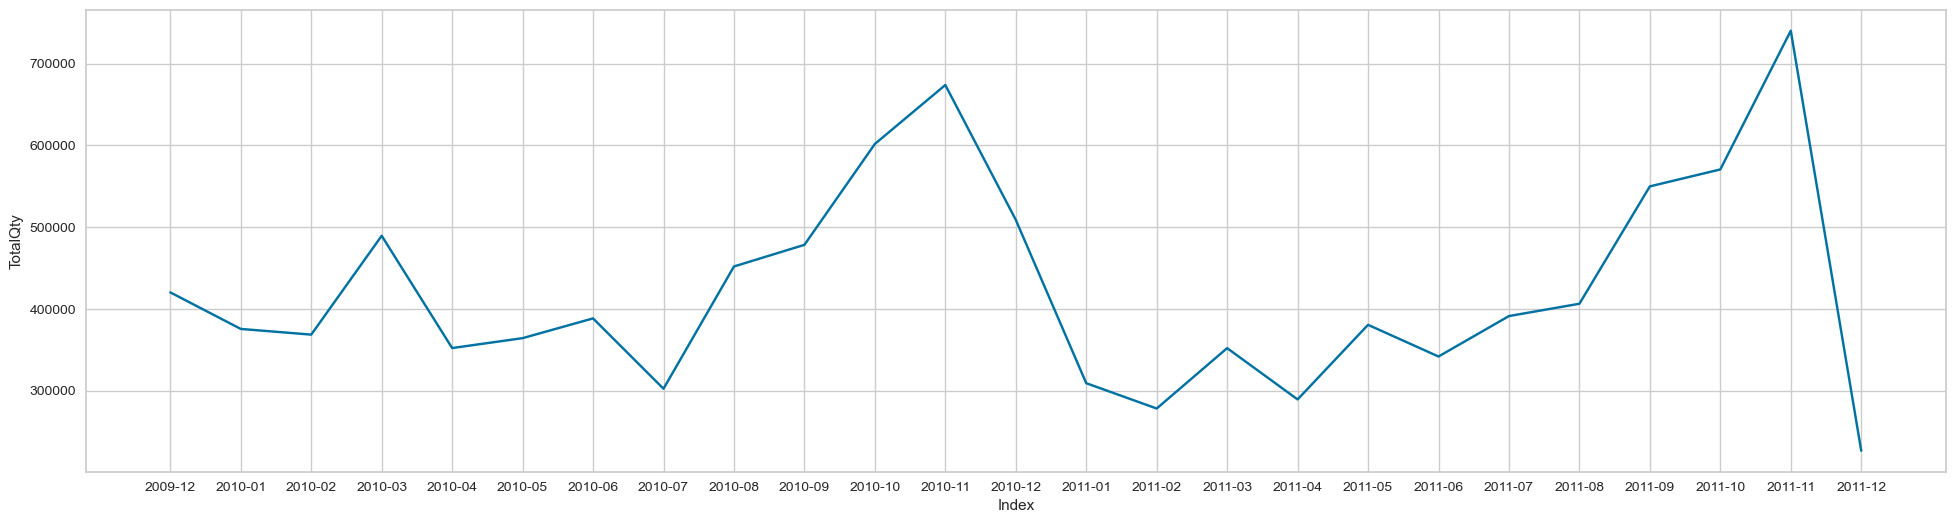

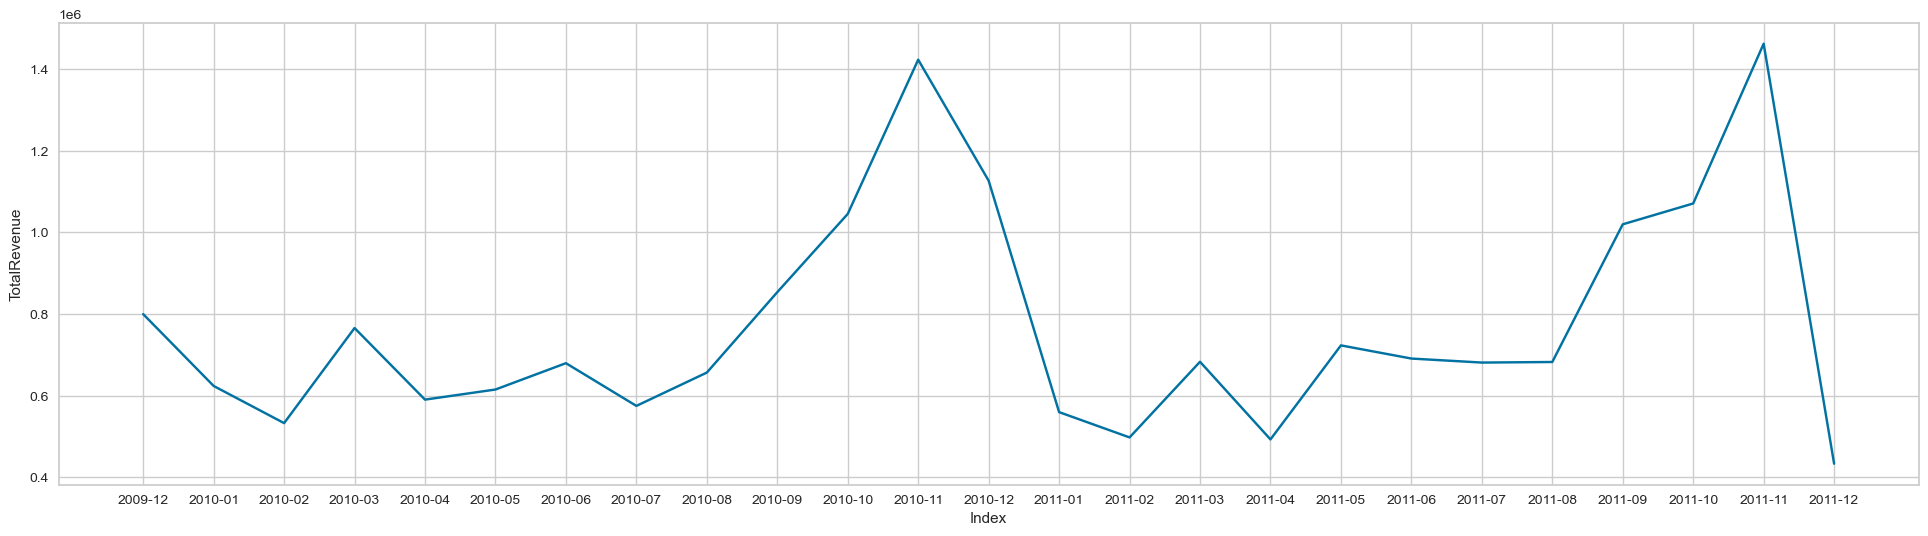

In [21]:
df_year_month = df["InvoiceDate"].dt.to_period("M")

df_trend = df.assign(Revenue=df['Quantity'] * df['Price']).groupby(by=df_year_month).agg(
    TotalQty=("Quantity", "sum"),
    TotalRevenue=("Revenue", "sum")
).reset_index()
df_trend["Index"] = df_trend.index

plt.figure(figsize=(24, 6))
ax = sns.lineplot(data=df_trend, x="Index", y="TotalQty")
ax.set_xticks(df_trend['Index'], labels=df_trend["InvoiceDate"])
plt.show()

plt.figure(figsize=(24, 6))
ax = sns.lineplot(data=df_trend, x="Index", y="TotalRevenue")
ax.set_xticks(df_trend['Index'], labels=df_trend["InvoiceDate"])
plt.show()


# Data Preparation

## Data Cleaning

In [22]:
df_clean = df.dropna(subset=["Customer ID"])

In [23]:
df_clean = df_clean.drop_duplicates()

In [24]:
invoice_str = df_clean["Invoice"].astype(str)
df_clean = df_clean[~invoice_str.str.startswith(('A', 'C'))]

In [25]:
df_clean["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts()

Invoice
______    779495
Name: count, dtype: int64

In [26]:
df_clean = df_clean[~df_clean["StockCode"].isin([
    'D', 'POST', "M", 'BANK CHARGES', 'ADJUST', 'PADS', 'DOT', 'AMAZONFEE', 'CRUK'
])]
df_clean = df_clean[~df_clean["StockCode"].astype(str).str.startswith(('TEST', 'SP', 'ADJUST', 'C'))]

In [27]:
df_clean.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [28]:
display(df_clean["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).unique())

array(['_____', '_____P', '_____W', '_____C', '_____B', '_____F',
       '_____L', '_____S', '_____A', '_____N', '_____E', '_____J',
       '_____D', '_____G', '_____LP', '_____BL', '_____K', '_____H',
       '_____M', '_____U', '_____GR', '_____R', '_____V', '_____T',
       '_____I', '_____O', '_____Z', '_____Y'], dtype=object)

In [29]:
df_clean = df_clean[df_clean["Price"] != 0]

In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776577 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      776577 non-null  object        
 1   StockCode    776577 non-null  object        
 2   Description  776577 non-null  object        
 3   Quantity     776577 non-null  int64         
 4   InvoiceDate  776577 non-null  datetime64[ns]
 5   Price        776577 non-null  float64       
 6   Customer ID  776577 non-null  float64       
 7   Country      776577 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 53.3+ MB


In [31]:
df_clean.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,776577.000000,776577,776577.000000,776577.000000
mean,13.519243,2011-01-03 00:44:11.290393600,2.934561,15326.605797
min,1.000000,2009-12-01 07:45:00,0.030000,12346.000000
25%,2.000000,2010-07-02 14:15:00,1.250000,13979.000000
50%,6.000000,2010-12-02 13:49:00,1.950000,15253.000000
75%,12.000000,2011-08-01 13:31:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,146.096695,NaN,4.293610,1692.861742


## Feature Engineering

In [32]:
snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Snapshot date {snapshot_date}")

Snapshot date 2011-12-10 12:50:00


In [33]:
df_rfm = df_clean.assign(
    TotalPrice=df_clean['Quantity'] * df_clean['Price']
).groupby("Customer ID").agg(
    Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    Frequency=("Invoice", "nunique"),
    Monetary=("TotalPrice", "sum")
).reset_index()
df_rfm.head(5)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,3,77352.96
1,12347.0,2,8,4921.53
2,12348.0,75,5,1658.40
3,12349.0,19,3,3678.69
4,12350.0,310,1,294.40


In [34]:
df_rfm_model = df_rfm.drop(columns=["Customer ID"])

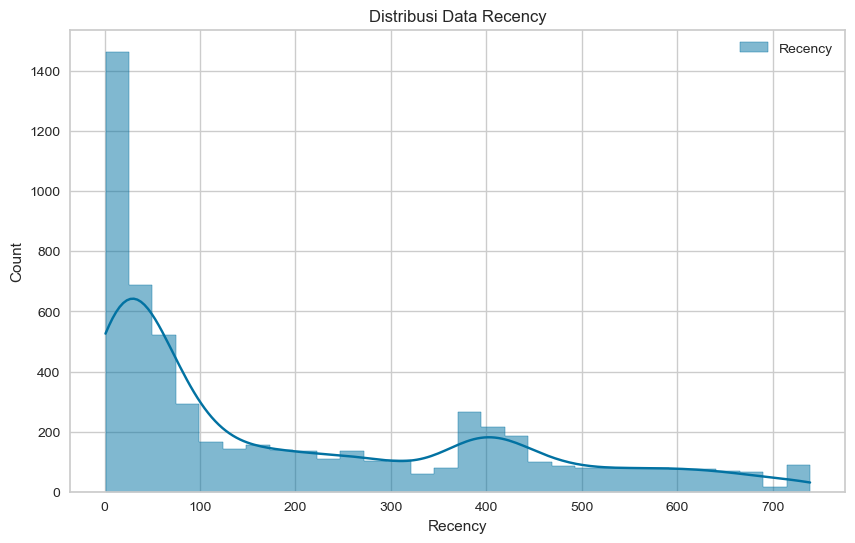

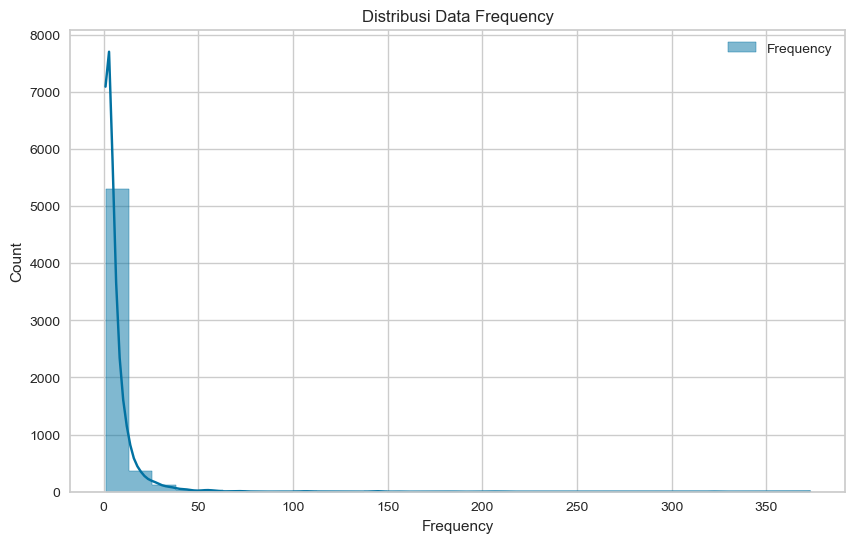

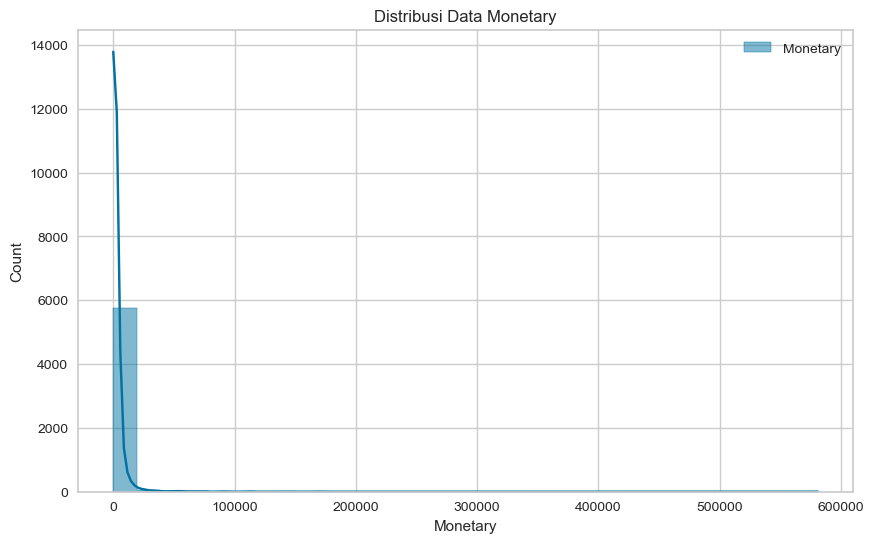

In [35]:
for feature in df_rfm_model.columns:
  plt.figure(figsize=(10, 6))
  sns.histplot(df_rfm[feature], kde=True, label=feature, bins=30, element='step')
  plt.title(f'Distribusi Data {feature}')
  plt.legend()
  plt.show()

In [ ]:
from scipy import stats


scaler = PowerTransformer(method='yeo-johnson')
df_rfm_scaled = df_rfm_model.copy()
features = df_rfm_scaled.columns.tolist()
df_rfm_scaled[features] = scaler.fit_transform(df_rfm_scaled[features])

In [37]:
df_rfm_scaled.describe()

,Recency,Frequency,Monetary
count,5.852000e+03,5.852000e+03,5.852000e+03
mean,1.517735e-16,4.553204e-16,3.399726e-17
std,1.000085e+00,1.000085e+00,1.000085e+00
min,-1.951341e+00,-1.264585e+00,-4.605021e+00
25%,-8.513281e-01,-1.264585e+00,-6.926378e-01
50%,-6.278005e-02,-1.113905e-02,-3.665716e-04
75%,9.948198e-01,8.499868e-01,6.830404e-01
max,1.609337e+00,2.504544e+00,3.971391e+00


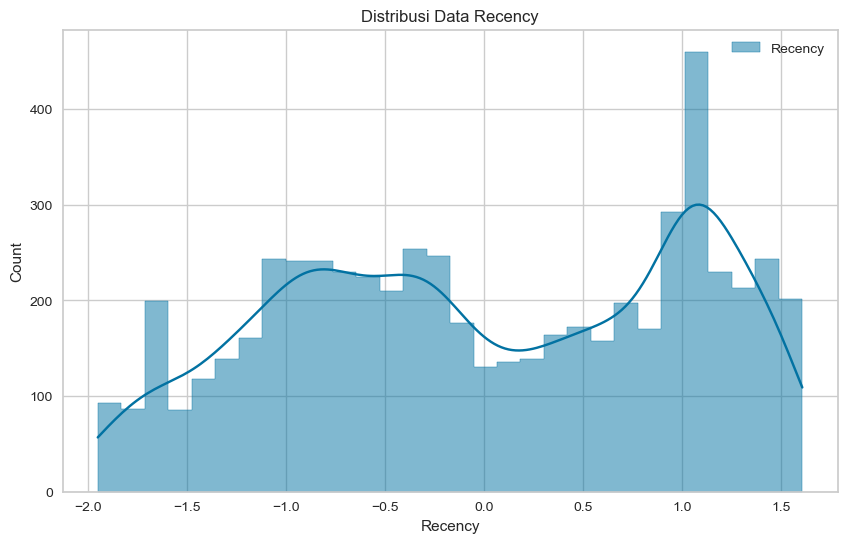

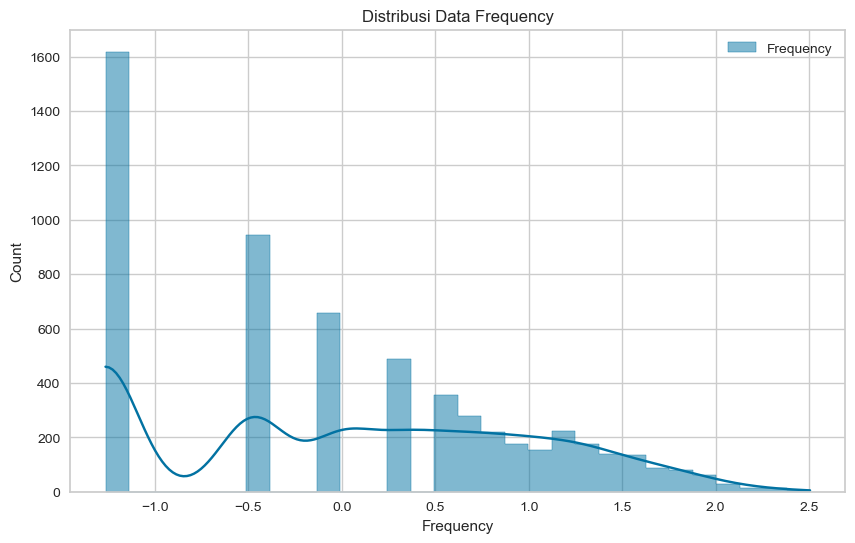

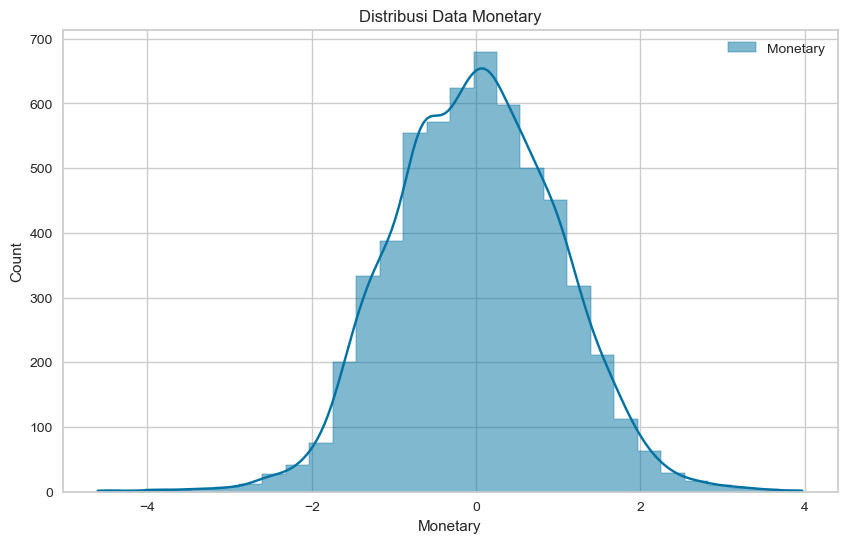

In [38]:
for feature in df_rfm_scaled.columns:
  plt.figure(figsize=(10, 6))
  sns.histplot(df_rfm_scaled[feature], kde=True, label=feature, bins=30, element='step')
  plt.title(f'Distribusi Data {feature}')
  plt.legend()
  plt.show()

# Modelling

c:\Users\WORKPLUS\miniconda3\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


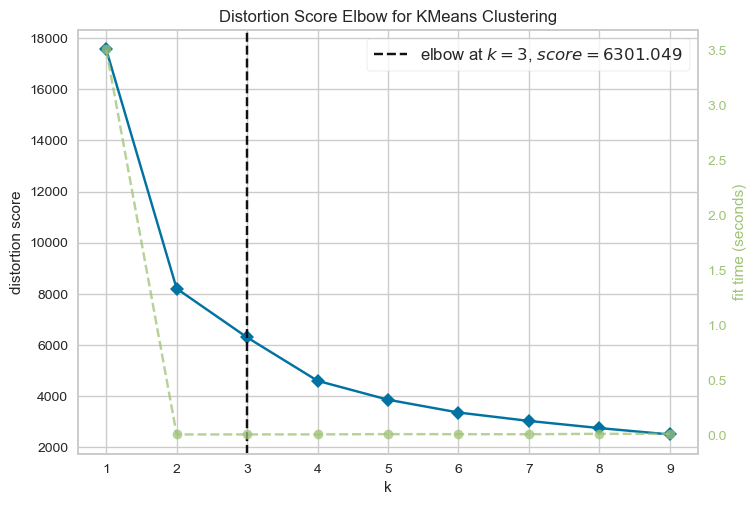

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 10))
visualizer.fit(df_rfm_scaled)
visualizer.show()

In [40]:
# kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_rfm_scaled)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [41]:
score = silhouette_score(df_rfm_scaled, kmeans.labels_)
score

0.3811026031446596

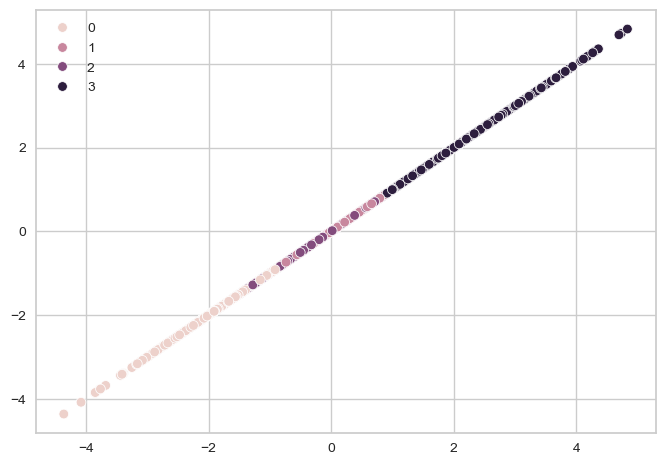

In [42]:
pca = PCA(n_components=2,random_state=42)
x_std_pca = pca.fit_transform(df_rfm_scaled)

plt.figure()
sns.scatterplot(x=x_std_pca[:, 0], y=x_std_pca[:, 0], hue=kmeans.labels_)
plt.show()

In [43]:
df_rfm_scaled["Cluster"] = kmeans.labels_
df_rfm_model["Cluster"] = kmeans.labels_
df_rfm["Cluster"] = kmeans.labels_

df_rfm.to_csv("clusterd.csv")

In [44]:
grouped_cluster = df_rfm.groupby("Cluster")
for column in df_rfm.columns:
  if (column == "Customer ID") | (column == "Cluster"): continue
  display(column)
  display(grouped_cluster[column].describe())

'Recency'

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1632.0,429.752451,171.115842,30.0,299.0,421.0,569.0,739.0
1,1393.0,268.164393,154.124920,44.0,139.0,239.0,386.0,738.0
2,1216.0,39.438322,29.751279,1.0,17.0,32.0,57.0,158.0
3,1611.0,30.225326,35.932400,1.0,8.0,19.0,40.0,372.0


'Frequency'

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1632.0,1.240196,0.455125,1.0,1.0,1.0,1.0,4.0
1,1393.0,4.557071,2.817448,1.0,3.0,4.0,5.0,41.0
2,1216.0,2.325658,1.167121,1.0,1.0,2.0,3.0,7.0
3,1611.0,15.762880,21.272229,2.0,7.0,11.0,17.0,373.0


'Monetary'

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1632.0,297.655074,238.160178,2.95,144.1125,243.625,376.9400,2300.40
1,1393.0,1698.028521,3050.353396,167.42,788.0100,1176.190,1858.9600,77352.96
2,1216.0,644.848215,451.462754,30.00,328.5800,554.575,849.0525,4366.78
3,1611.0,8338.488970,26344.940635,485.69,2248.1100,3724.060,6907.4750,580987.04


In [45]:
def get_intervals(series):
    bins = pd.qcut(series, 5, duplicates='drop')
    return bins.cat.categories

recency_intervals = get_intervals(df_rfm["Recency"]) 
frequency_intervals = get_intervals(df_rfm["Frequency"])
monetary_intervals = get_intervals(df_rfm["Monetary"])

grouped_cluster = df_rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean"  
}).reset_index()

# print(recency_intervals)
# print(frequency_intervals)
# print(monetary_intervals)

for index, row in grouped_cluster.iterrows():
    recency_score = 5 - recency_intervals.get_loc(row["Recency"])
    frequency_score = frequency_intervals.get_loc(row["Frequency"]) + 1
    monetary_score = monetary_intervals.get_loc(row["Monetary"]) + 1
    print(f"Cluster {row["Cluster"]}, {recency_score}-{frequency_score}-{monetary_score}")
    # print(f"Mean {row["Recency"]}, {row["Frequency"]}, {row["Monetary"]}")

# df_rfm["Score"] = df_rfm.apply(lambda x: )

Cluster 0.0, 1-1-2
Cluster 1.0, 2-3-4
Cluster 2.0, 4-2-3
Cluster 3.0, 4-4-5


Cluster
0    1632
3    1611
1    1393
2    1216
Name: count, dtype: int64

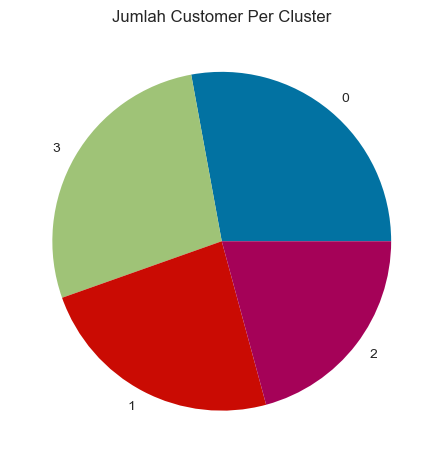

In [46]:
vals = df_rfm["Cluster"].value_counts()
display(vals)
plt.pie(vals, labels=vals.index)
plt.title('Jumlah Customer Per Cluster')
plt.show()

Cluster,0,1,2,3
Recency,1.0,0.595552,0.023060,0.0
Frequency,0.0,0.228393,0.074743,1.0
Monetary,0.0,0.174158,0.043179,1.0


<Axes: title={'center': 'Snake Plot Cluster'}>

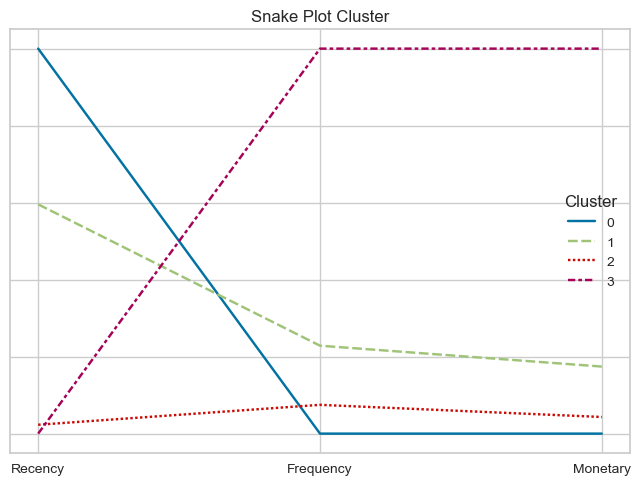

In [47]:
data_snake = df_rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean"
})
features = ["Recency", "Frequency", "Monetary"]
data_snake[features] = MinMaxScaler().fit_transform(data_snake[features])
display(data_snake.T)
ax = sns.lineplot(data_snake.T)
ax.set_yticklabels([])
ax.set_title("Snake Plot Cluster")
ax

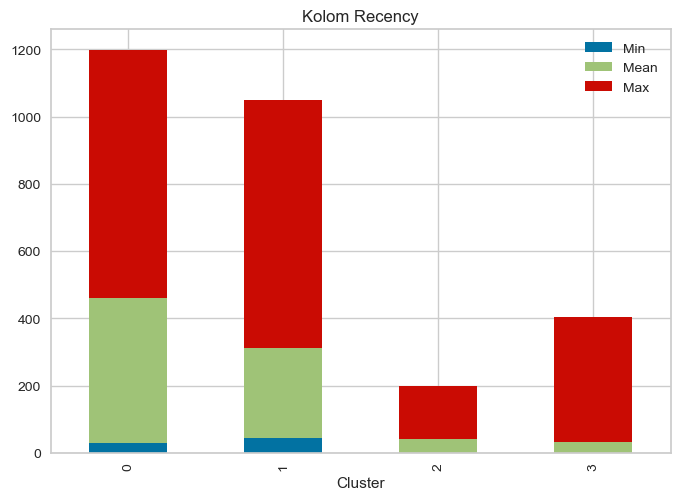

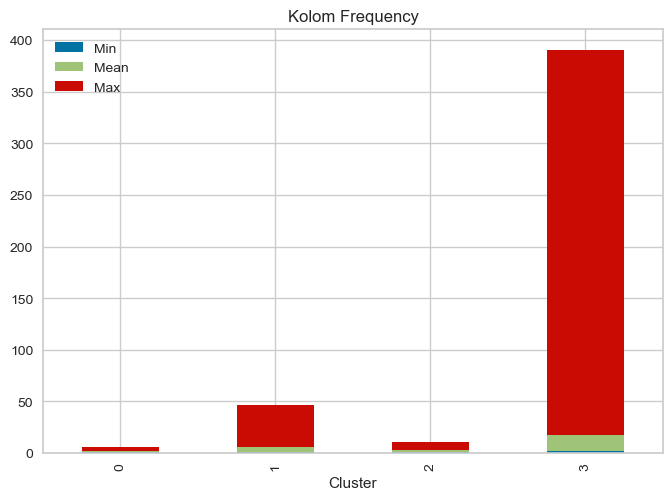

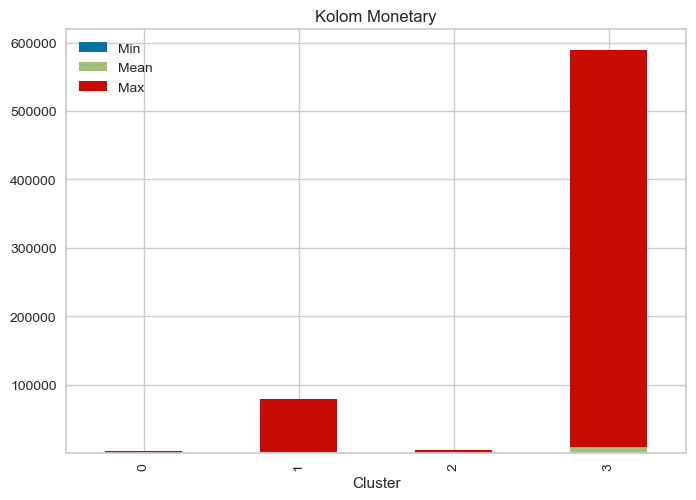

In [48]:
grouped_cluster = df_rfm.groupby("Cluster")
for column in df_rfm.columns:
  if (column == "Customer ID") | (column == "Cluster"): continue
  column_data = grouped_cluster.agg(
      Min=(column, "min"),
      Mean=(column, "mean"),
      Max=(column, "max"),
  )
  column_data.plot(kind='bar', stacked=True)

  plt.title(f"Kolom {column}")
  plt.show()

Recency
 
- Cluster 0 (Potential Churn): Pada cluster ini, segmentasi pelanggan dimana recency pelanggan sangat buruk. Rata-rata di angka 450~. Kelompok ini rata-rata sudah lebih dari 1 tahun tidak kembali melakukan transaksi. Ini adalah kelompok yang kemungkinan besar churn.
- Cluster 1 (About to sleep): Pada cluster ini, segmentasi pelanggan dimana recency pelanggan buruk.  Rata-rata di angka 300 hari~. Memerlukan win-back strategy sebelum mereka berpindah ke cluster 0.
- Cluster 2 (Recent & Consistent): Pada cluster ini, segmentasi pelanggan dimana recency pelanggan rata-rata masih bagus, tidak melebihi dari 200 hari. Batas Max yang pendek menunjukan kelompok ini consistent. Tidak ada satupun customer di kelompok ini yang absen lebih dari 200 hari. Ini merupakan pelanggan aktif.
- Cluster 3 (Recent but High Variance): Pada cluster ini, segmentasi pelanggan dimana bersifat campuran. Karena ada pada kelompok ini yang sudah agak lama tidak melakukan transaksi, sekitar 400 hari

Frequency 

- Cluster 0 (Lost & Low Value): Frequency sangat buruk. Rata-rata sangat buruk, hanya mencapai angka 1-2 saja.  
- Cluster 1 (At Risk): Frequency sangat buruk. Rata-rata kurang dari 50. Pelanggan ini merupakan pelanggan lama, yang sekarang sepertinya jarang aktif. 
- Cluster 2 (New Customer): Rata-rata sangat kecil pada kelompok ini. Salah satu customer saja tidak sampai 50x transaksi. Melihat data recency, sepertinya kelompok ini adalah pelanggan baru. Kelompok ini bisa masuk potential customers.
- Cluster 3 (The Wheels): Rata-rata lumayan bagus berada di angka 15~ dan salah satu customer berada di angka hampir 400. Kelompok ini bisa menjadi potensi positif. Ada sultan disini karena max hampir 400

Monetary 

- Cluster 0 (Lost/Low Value): Monetary sangat jelek. Rata-rata 100 
- Cluster 1 (At Risk): Max berada di angka kurang dari 100.000
- Cluster 2 (New Potential): Max Monetary masih rendah, kemungkinan karena pelanggan baru.
- Cluster 3 (The Wheels): Rata-rata rendah, tetapi max tinggi karena freqeuncy nya juga tinggi.

Summary : 
- Cluster 0 (Lost/Low Value): 
    - RFM Score ketiganya sangat rendah 
    - User pada kelompok ini sudah sangat lama tidak melakukan transaksi dan kontribusi uangnya sangat kecil. 
    - Lebih baik jangan gunakan menghabiskan uang untuk segmen pelanggan ini. 
- Cluster 1 (At Risk):
    - RFM Score hanya nilai monetary yang lumayan bagus. 
    - User yang dulu pernah belanja, namun sekarang sudah mulai pergi meninggalkan platform. Beresiko masuk ke cluster 0. 
    - Disarankan menggunakan Win-Back Campaign. 
- Cluster 2 (New Potential):
    - RFM Score, nilai recency bagus, namun masih perlu usaha untuk meningkatkan nilai frequency dan monetary 
    - User pada segmen ini adalah pelanggan baru, belum banyak melakukan pembelian, namun bersifat aktif. 
    - Disarankan edukasi lebih lanjut terkait produk, berikan rekomendasi barang, segmen yang oke untuk melakukan investasi. 
- Cluster 3 (Champions): 
    - RFM Score hampir sempurna. Perlu dipertahankan. 
    - User pada segmen ini lumayan aktif, dan juga memberikan kontribusi yang besar pada omzet penjualan 
    - Disarankan untuk sangat mempertahankan segmen ini, perbanyak jumlah customer yang possible masuk cluster ini, Tidak perlu banyak perubahan, intinya mempertahankan dan kalau bisa mengembangkan lagi.

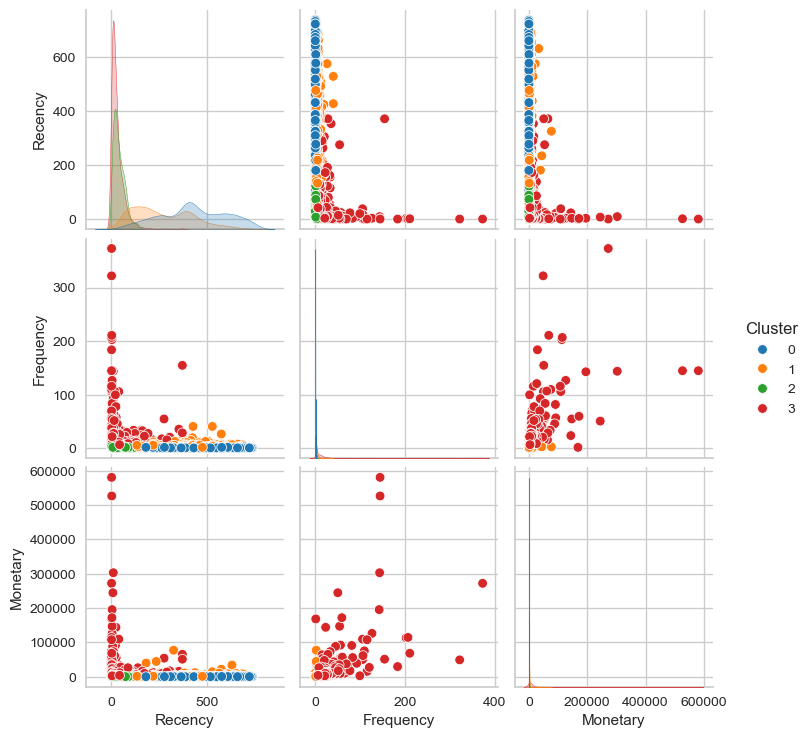

In [49]:
sns.pairplot(df_rfm, vars=['Recency','Frequency','Monetary'], hue='Cluster', palette='tab10')
plt.show()

In [50]:
import joblib 
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'model.pkl')

['model.pkl']